#### Library import

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [8]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [9]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9758649577328995954
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1062566317179750372
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [11]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [12]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [13]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [14]:
As = data
Cd = data
Ni = data

In [15]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [16]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [17]:
import smogn

In [18]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 167.32it/s]


In [19]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(2183, 16)
(2151, 16)
(2183, 16)


#### Eliminate outlier and train / test split

In [20]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [21]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [22]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [23]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [24]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1663, 15)
(1771, 15)
(2068, 15)


StandardScaler

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

MinMaxScaler

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [26]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1330, 15)
(1416, 15)
(1654, 15)


#### 10-Fold Crossvalidation

In [27]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optimize Model study

##### As

In [28]:
As_rf_params = {
    "random_state": 42,
    "n_estimators": 71,
    "max_depth": 10,
    "min_samples_leaf": 1,
    "min_samples_split": 2
}

As_SVM_params = {
    "C": 4.194004895739116,
    "epsilon": 0.17942261460899583,
    "kernel": 'rbf',
    "degree": 1
}

As_GBM_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": 176,
    "max_depth": 12,
    "min_samples_leaf": 9,
    "min_samples_split": 5,
    "subsample": 0.48563243815157614
}

As_LGBM_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": 909,
    "max_depth": 13,
    "num_leaves": 32,
    "min_child_samples": 2,
    "num_iterations": 849
}

In [29]:
# RF
As_rf = RandomForestRegressor(**As_rf_params)
As_rf.fit(As_X_train, As_y_train)

# SVM
As_SVM = SVR(**As_SVM_params)
As_SVM.fit(As_X_train, As_y_train)

# GBM
As_gb = GradientBoostingRegressor(**As_GBM_params)
As_gb.fit(As_X_train, As_y_train)

# LGBM
As_lgbm = LGBMRegressor(**As_LGBM_params)
As_lgbm.fit(As_X_train, As_y_train)

LGBMRegressor(max_depth=13, min_child_samples=2, n_estimators=909,
              num_iterations=849, num_leaves=32, random_state=42)

#### As SHAP

In [30]:
import shap

In [31]:
# features Declaration

features = ['pH', 'slope', 'altitude', 'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'SOL_K1','CLAY1','SILT1','SAND1','ROCK1','distance']

In [42]:
# RF
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

As_RF_explainer = shap.TreeExplainer(As_rf)
As_RF_shap_values = As_RF_explainer.shap_values(As_X_test)

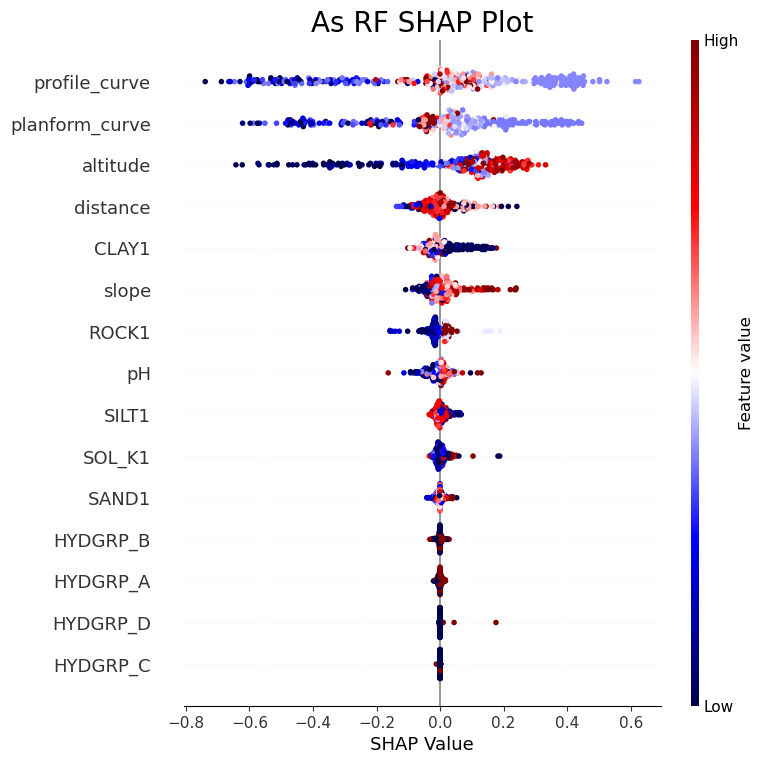

In [43]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(As_RF_shap_values, As_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('As RF SHAP Plot', fontsize=20)
plt.show()

In [44]:
# GBM
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

As_GBM_explainer = shap.TreeExplainer(As_gb)
As_GBM_shap_values = As_GBM_explainer.shap_values(As_X_test)

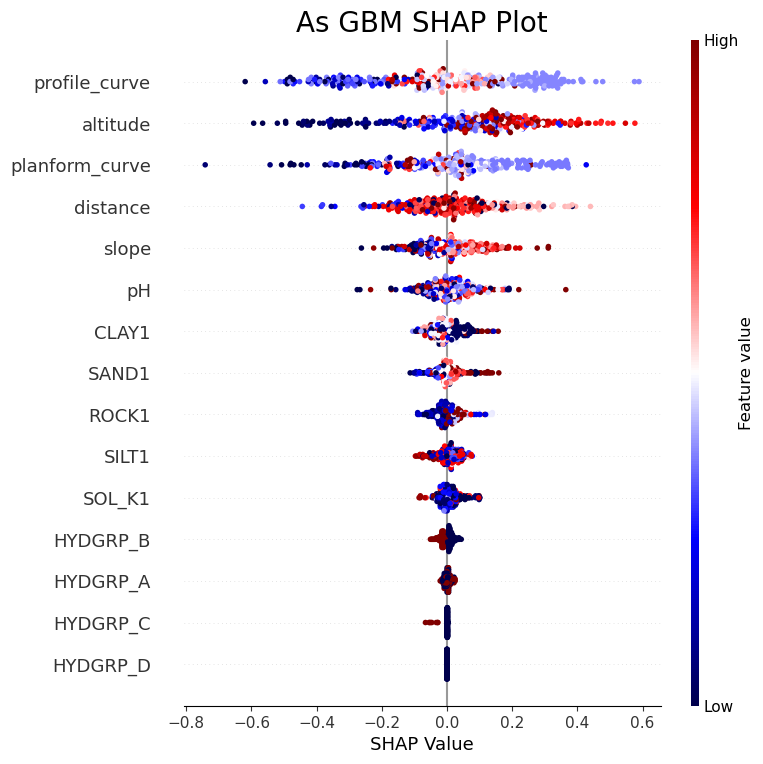

In [45]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(As_GBM_shap_values, As_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('As GBM SHAP Plot', fontsize=20)
plt.show()

In [46]:
# LGBM
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

As_LGBM_explainer = shap.TreeExplainer(As_lgbm)
As_LGBM_shap_values = As_LGBM_explainer.shap_values(As_X_test)

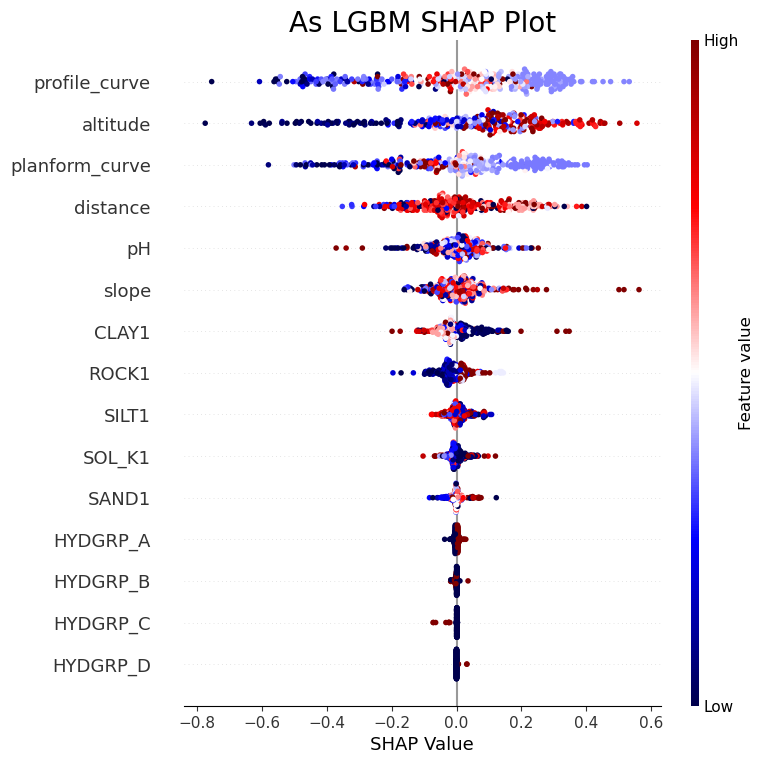

In [47]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(As_LGBM_shap_values, As_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('As LGBM SHAP Plot', fontsize=20)
plt.show()

In [ ]:
# SVM
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

As_SVM_explainer = shap.KernelExplainer(As_SVM.predict, As_X_train)
As_SVM_shap_values = As_SVM_explainer.shap_values(As_X_test, nsamples = 100)

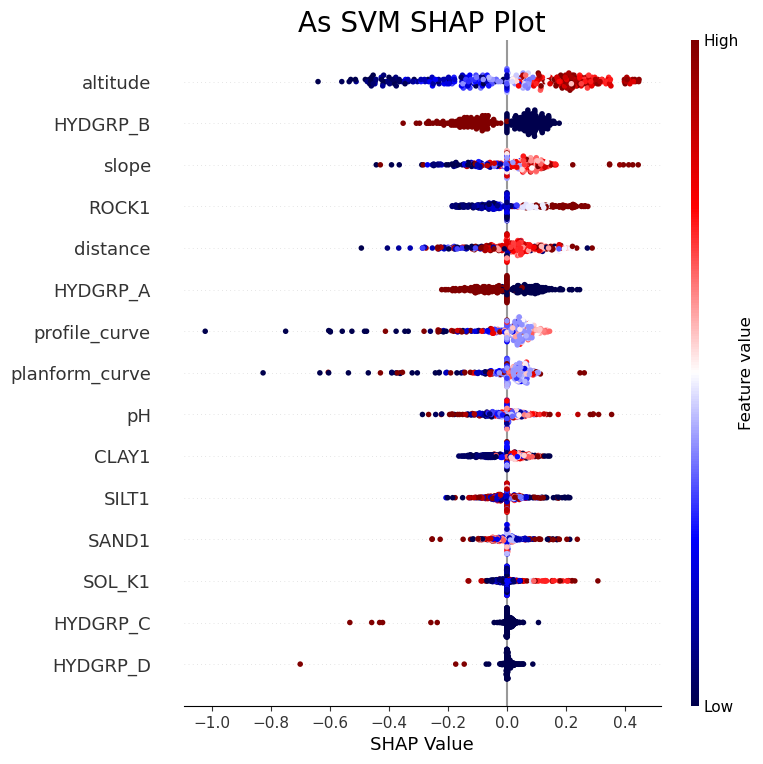

In [ ]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(As_SVM_shap_values, As_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('As SVM SHAP Plot', fontsize=20)
plt.show()

##### Cd

In [48]:
Cd_rf_params = {
    "random_state": 42,
    "n_estimators": 92,
    "max_depth": 10,
    "min_samples_leaf": 2,
    "min_samples_split": 3
}

Cd_SVM_params = {
    "C": 4.772653486826759,
    "epsilon": 0.06478694108269326,
    "kernel": 'rbf',
    "degree": 1
}

Cd_GBM_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": 144,
    "max_depth": 16,
    "min_samples_leaf": 8,
    "min_samples_split": 8,
    "subsample": 0.42660183516459393
}

Cd_LGBM_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": 865,
    "max_depth": 22,
    "num_leaves": 11,
    "min_child_samples": 10,
    "num_iterations": 544
}

In [49]:
# RF
Cd_rf = RandomForestRegressor(**Cd_rf_params)
Cd_rf.fit(Cd_X_train, Cd_y_train)

# SVM
Cd_SVM = SVR(**Cd_SVM_params)
Cd_SVM.fit(Cd_X_train, Cd_y_train)

# GBM
Cd_gb = GradientBoostingRegressor(**Cd_GBM_params)
Cd_gb.fit(Cd_X_train, Cd_y_train)

# LGBM
Cd_lgbm = LGBMRegressor(**Cd_LGBM_params)
Cd_lgbm.fit(Cd_X_train, Cd_y_train)

LGBMRegressor(max_depth=22, min_child_samples=10, n_estimators=865,
              num_iterations=544, num_leaves=11, random_state=42)

##### Cd SHAP

In [53]:
# RF
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

Cd_RF_explainer = shap.TreeExplainer(Cd_rf)
Cd_RF_shap_values = Cd_RF_explainer.shap_values(Cd_X_test)

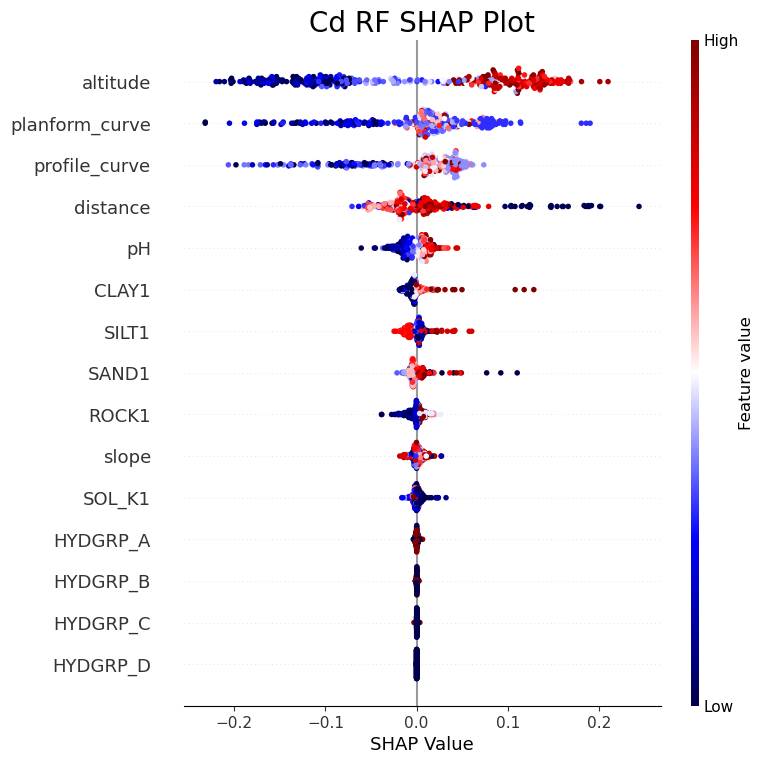

In [54]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(Cd_RF_shap_values, Cd_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('Cd RF SHAP Plot', fontsize=20)
plt.show()

In [55]:
# GBM
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

Cd_GBM_explainer = shap.TreeExplainer(Cd_gb)
Cd_GBM_shap_values = Cd_GBM_explainer.shap_values(Cd_X_test)

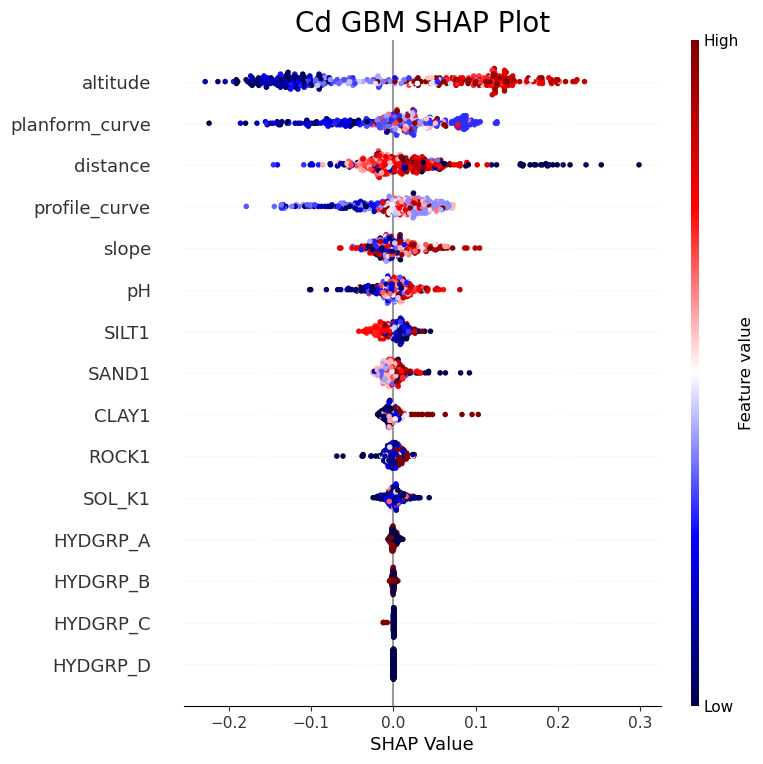

In [56]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(Cd_GBM_shap_values, Cd_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('Cd GBM SHAP Plot', fontsize=20)
plt.show()

In [61]:
# LGBM
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

Cd_LGBM_explainer = shap.TreeExplainer(Cd_lgbm)
Cd_LGBM_shap_values = Cd_LGBM_explainer.shap_values(Cd_X_test)

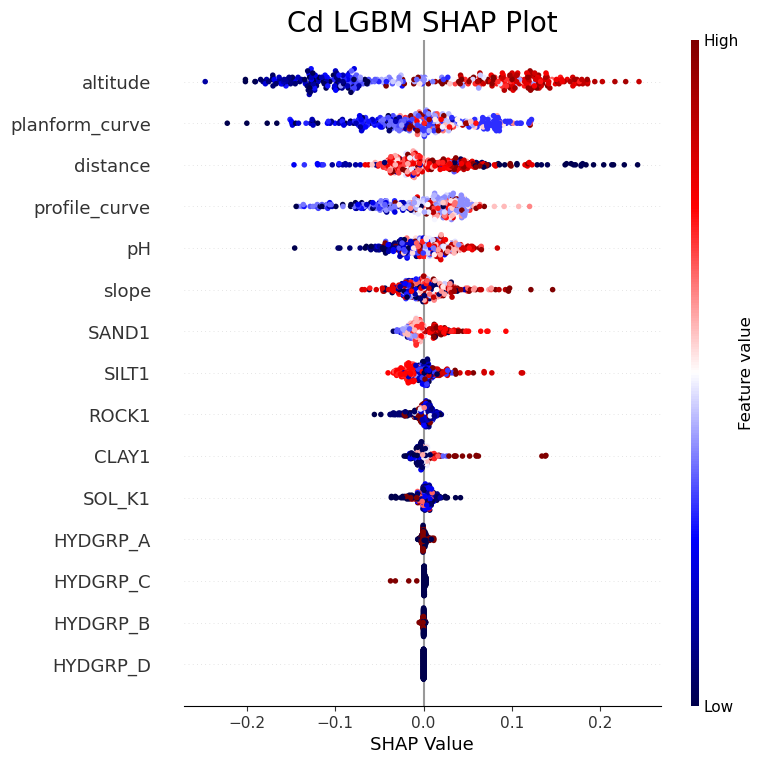

In [62]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(Cd_LGBM_shap_values, Cd_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('Cd LGBM SHAP Plot', fontsize=20)
plt.show()

In [51]:
# SVM
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

Cd_SVM_explainer = shap.KernelExplainer(Cd_SVM.predict, Cd_X_train)
Cd_SVM_shap_values = Cd_SVM_explainer.shap_values(Cd_X_test, nsamples = 100)

Using 1416 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/355 [00:00<?, ?it/s]

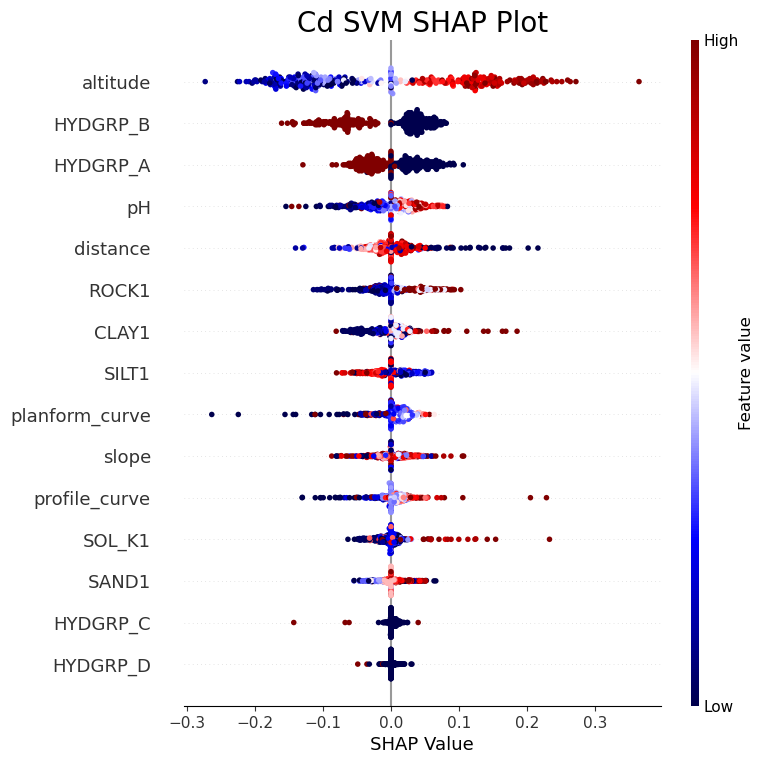

In [52]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(Cd_SVM_shap_values, Cd_X_test, cmap='seismic', feature_names = features, show = False)

ax.set_xlabel('SHAP Value')
ax.set_title('Cd SVM SHAP Plot', fontsize=20)
plt.show()

##### Ni